<a href="https://colab.research.google.com/github/Rtniewi/kcwiertniewicz-IDS/blob/main/Problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

//***Katrina Cwiertniewicz
//*** CSC 330
//10/11/2024
//Assignment 3: VAE on the SVHN Dataset
####The purpose of this assignment is to create and train a Variational Autoencoder model in Keras to learn representations of the Street View House Numbers dataset and explore its performance with different latent dimensions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm

## 0. Parameters <a name="parameters"></a>

In [2]:
IMAGE_SIZE = 32
BATCH_SIZE = 128
VALIDATION_SPLIT = 0.2
EPOCHS = 50
BETA = 500

# Task 1: Load and Preprocess the SVHN Dataset

In [3]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2024-10-10 22:43:05--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  3.00MB/s    in 65s     

2024-10-10 22:44:10 (2.67 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2024-10-10 22:44:10--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  1.67MB/s    in 21s     

2024-10-10 22:44:32 (2.86 MB/s) - ‘test_32x32.mat’ saved [64275384/64

In [4]:
from scipy.io import loadmat

# Load data
train_data = loadmat('train_32x32.mat')
test_data = loadmat('test_32x32.mat')

# Preprocess the data
x_train = np.transpose(train_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0
y_train = train_data['y'].flatten()
x_test = np.transpose(test_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0
y_test = test_data['y'].flatten()

# Display the shape of the datasets
print(f'Training data shape: {x_train.shape}')
print(f'Test data shape: {x_test.shape}')



Training data shape: (73257, 32, 32, 3)
Test data shape: (26032, 32, 32, 3)


# Task 2: Build a Variational Autoencoder

In [5]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [6]:
def build_vae(latent_dim):
  # Encoder
  encoder_input = layers.Input(
      shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="encoder_input"
  )
  x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
      encoder_input
  )
  x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
  shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

  x = layers.Flatten()(x)
  z_mean = layers.Dense(latent_dim, name="z_mean")(x)
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
  z = Sampling()([z_mean, z_log_var])

  encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
  encoder.summary()

  # Decoder

  decoder_input = layers.Input(shape=(latent_dim,), name="decoder_input")
  x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
  x = layers.Reshape(shape_before_flattening)(x)
  x = layers.Conv2DTranspose(
      128, (3, 3), strides=2, activation="relu", padding="same"
  )(x)
  x = layers.Conv2DTranspose(
      64, (3, 3), strides=2, activation="relu", padding="same"
  )(x)
  x = layers.Conv2DTranspose(
      32, (3, 3), strides=2, activation="relu", padding="same"
  )(x)
  decoder_output = layers.Conv2D(
      3,
      (3, 3),
      strides=1,
      activation="sigmoid",
      padding="same",
      name="decoder_output",
  )(x)

  decoder = models.Model(decoder_input, decoder_output)
  decoder.summary()

  # Create a variational autoencoder
  vae = VAE(encoder, decoder)
  return vae

In [7]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


# 3. Train the VAE with different Latent Dimensions

In [8]:
def main():
  latent_dims = [2,5,10]
  global vae
  for dim in latent_dims:
      print(f'Training VAE with latent dimension: {dim}')
      vae = build_vae(latent_dim=dim)
      vae.compile(optimizer='adam', loss=losses.binary_crossentropy)
      vae.fit(x_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test, x_test))

main()

Training VAE with latent dimension: 2
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 32)           896       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_1[0][0]']            
                                                      

# Task 4: Visualize the Results

# Reconstruct using the variational autoencoder

In [9]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [10]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Examples of real house numbers")
display(example_images)
print("Reconstructions")
display(reconstructions)

157/157 [==============================] - 2s 9ms/step
Examples of real house numbers


array([[[[0.14901961, 0.40392157, 0.23529412],
         [0.15294118, 0.40784314, 0.23921569],
         [0.15294118, 0.40784314, 0.24313726],
         ...,
         [0.16078432, 0.4       , 0.23921569],
         [0.16470589, 0.40392157, 0.24313726],
         [0.15294118, 0.38039216, 0.22352941]],

        [[0.15294118, 0.40784314, 0.23921569],
         [0.15294118, 0.40784314, 0.23921569],
         [0.15294118, 0.40784314, 0.24313726],
         ...,
         [0.16078432, 0.4       , 0.23921569],
         [0.16862746, 0.39607844, 0.24705882],
         [0.15294118, 0.38039216, 0.22352941]],

        [[0.14901961, 0.4117647 , 0.24313726],
         [0.14509805, 0.40784314, 0.23921569],
         [0.15294118, 0.41568628, 0.24705882],
         ...,
         [0.16862746, 0.39607844, 0.24705882],
         [0.16862746, 0.39215687, 0.2509804 ],
         [0.15294118, 0.38039216, 0.23137255]],

        ...,

        [[0.20392157, 0.46666667, 0.30588236],
         [0.20784314, 0.47058824, 0.30980393]

Reconstructions


array([[[[0.28177175, 0.26972786, 0.26539356],
         [0.276444  , 0.26691496, 0.2641465 ],
         [0.2734561 , 0.2597051 , 0.2581616 ],
         ...,
         [0.28026313, 0.2713888 , 0.26662827],
         [0.2837112 , 0.27434027, 0.2666082 ],
         [0.28590834, 0.27721938, 0.2750189 ]],

        [[0.27770376, 0.2687799 , 0.2650143 ],
         [0.275348  , 0.26265335, 0.264614  ],
         [0.2653529 , 0.2561957 , 0.26152363],
         ...,
         [0.28084183, 0.2725075 , 0.26810855],
         [0.27627632, 0.27063355, 0.27050525],
         [0.28374815, 0.27498958, 0.27429625]],

        [[0.28520215, 0.26838717, 0.26514012],
         [0.27051473, 0.26333335, 0.26208097],
         [0.2694755 , 0.25998402, 0.26390696],
         ...,
         [0.2769538 , 0.27176467, 0.26758456],
         [0.2850854 , 0.2767012 , 0.27295095],
         [0.29544416, 0.28428444, 0.28075767]],

        ...,

        [[0.30015323, 0.29225412, 0.29154873],
         [0.29155374, 0.28879312, 0.28788543]

# Embed using the Encoder

In [11]:
# Encode the example images
z_mean, z_var, z = vae.encoder.predict(example_images)

157/157 [==============================] - 1s 3ms/step


In [12]:
# Some examples of the embeddings
print(z[:10])

[[ 0.83901167  0.00838569 -0.02241939 -0.19925253 -0.6167544   1.5264148
  -0.08788793 -1.3001887   2.1738088  -0.80158484]
 [ 0.10680258  0.6787694  -0.41551515  1.3395145  -0.973316    0.6234003
   0.10219768  1.1082237   0.41193128 -0.8396045 ]
 [ 0.38971266 -0.70508707 -0.7573571  -0.9390499  -0.12127629 -1.239052
   1.418803    0.8749481  -0.11861619  0.08699143]
 [-0.6795676   0.19251958  0.5411491  -1.3307884  -0.45601097  0.3561058
  -0.23264226  0.8324173   1.6694858  -0.13344407]
 [ 0.13146791  1.0335946  -0.2697175   0.8605237   0.61280495 -1.3720223
   0.73199546  1.1254824  -0.5825789  -0.21593106]
 [ 0.19803132  1.2333901  -0.06863657 -1.3427898  -0.76472837  0.3249925
   0.91544485 -0.282449   -0.81101674 -1.3472884 ]
 [ 1.7308377   0.08412898  0.2616757  -0.48628622 -0.10791615 -0.01253607
   0.4224892  -3.0670376   1.8388798   0.980424  ]
 [-0.5181134   1.3738402  -0.43737787  2.153562    1.5128795  -0.3003195
  -0.24901131 -1.1652598  -0.10173953  2.8392537 ]
 [-0.156

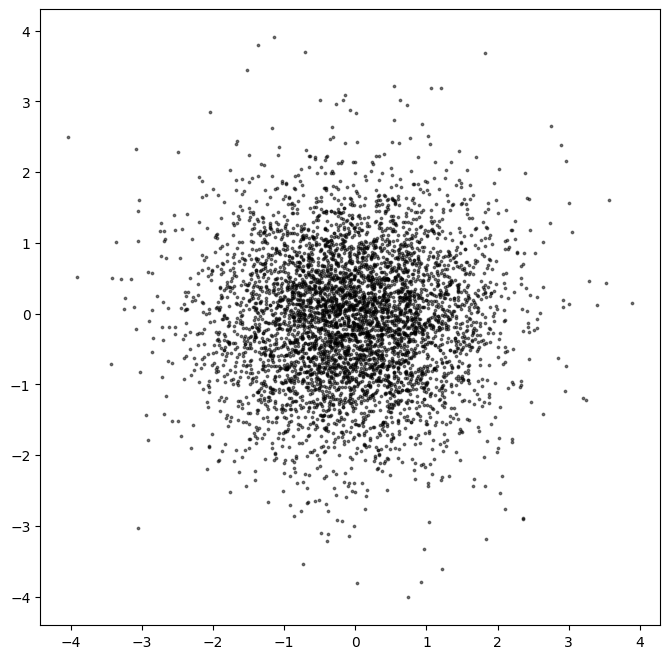

In [13]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

# Generate using the decoder

In [14]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 10))

In [15]:
# Decode the sampled points
reconstructions = vae.decoder.predict(z_sample)

1/1 [==============================] - 0s 102ms/step


In [16]:
# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

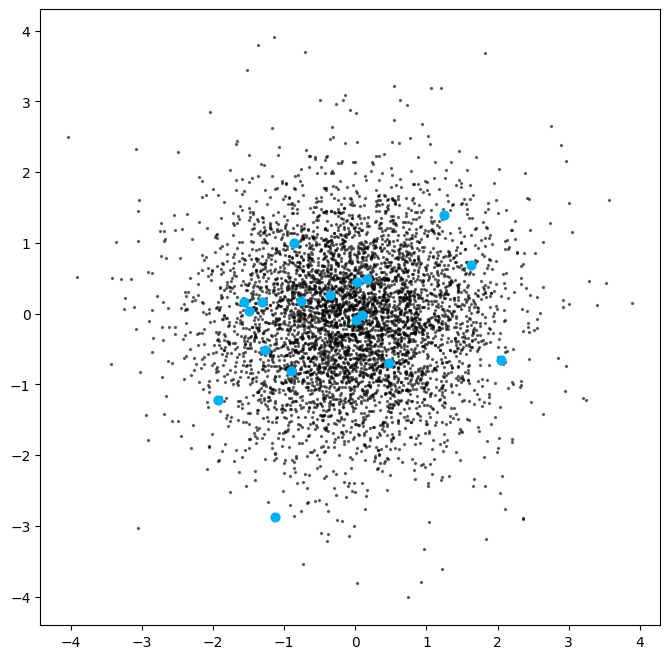

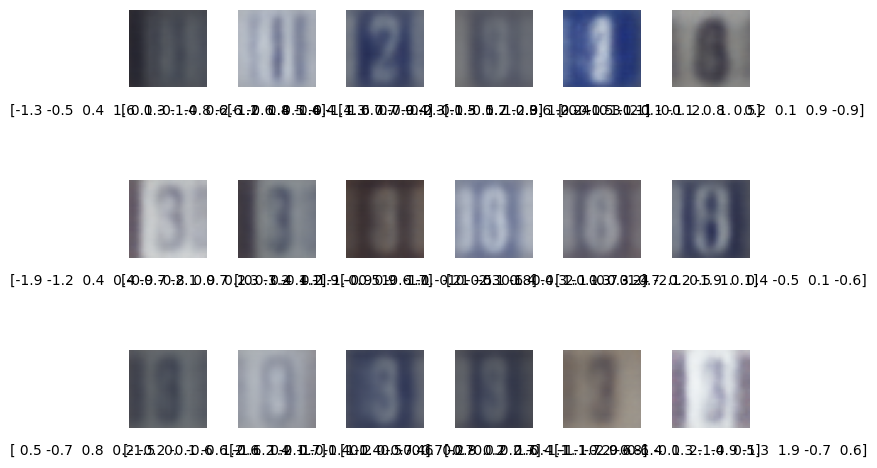

In [17]:
sample = norm.cdf(z_sample)
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

# Explore the latent space

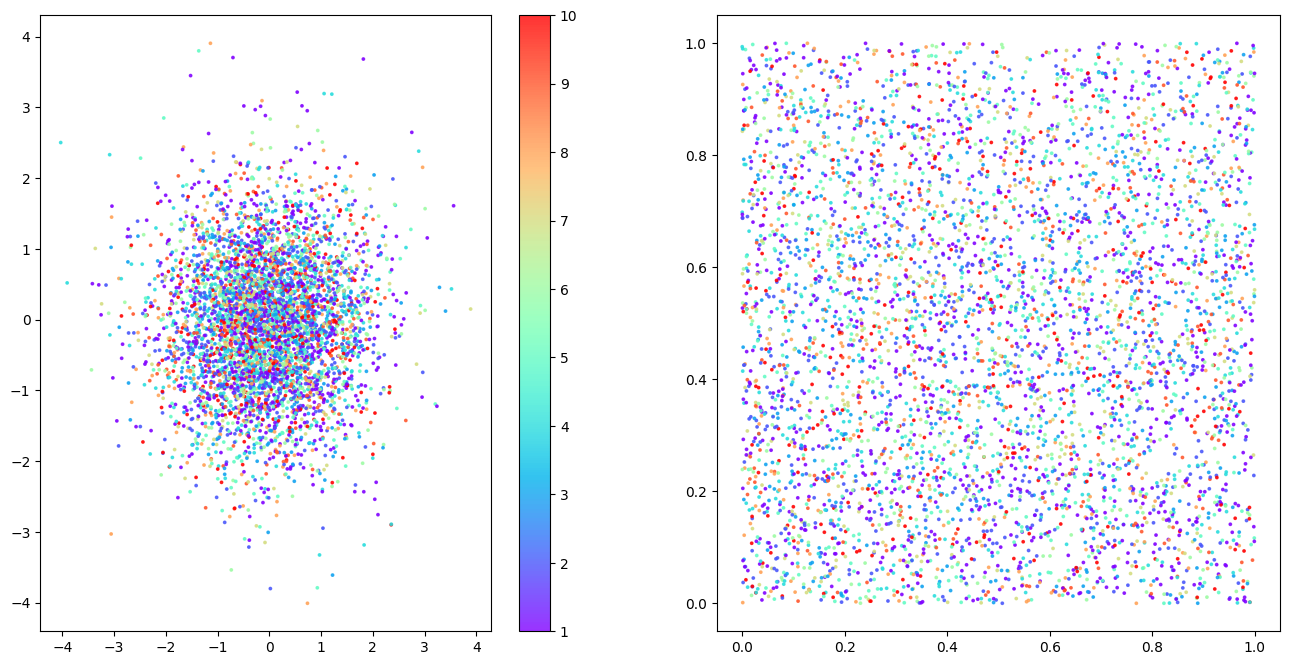

In [18]:
# Colour the embeddings by their label
figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()